MODEL TRAINING WITH WHOIS

In [1]:
# ===============================
# 1️⃣ Imports
# ===============================
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [2]:
# ===============================
# 2️⃣ Load dataset
# ===============================
input_path = r"D:\QRMODELTRAINING\CSVFILES\QrusaderFeaturesWhois.csv"
df = pd.read_csv(input_path)

# Encode Label -> 0 = benign, 1 = malicious
df['Label_encoded'] = df['Label'].map({'benign': 0, 'malicious': 1})

# Define numeric and binary features
numeric_features = [
    'url_length', 'subdomain_count', 'path_depth', 'digit_letter_ratio',
    'special_char_ratio', 'repeated_char_count', 'domain_entropy',
    'path_entropy', 'long_subdomain_length', 'query_param_count',
    'vowel_count', 'consonant_count', 'digit_special_ratio',
    'max_path_segment_length', 'domain_age_days', 'expiration_days', 'registration_length', 'ns_count'
]

# Updated binary features
binary_features = [
    'has_ip', 'https_token', 'url_has_suspicious_keywords', 'has_multiple_subdomains', 'domain_age_missing', 'dns_record', 'registrar_known', 'whois_privacy'
]



features = numeric_features + binary_features
label = 'Label_encoded'

X = df[features]
y = df[label]

print("✅ Dataset ready:")
print(f"Features shape: {X.shape}")
print(f"Label distribution:\n{y.value_counts()}")


✅ Dataset ready:
Features shape: (19998, 26)
Label distribution:
Label_encoded
1    9999
0    9999
Name: count, dtype: int64


In [3]:
# ===============================
# 3️⃣ Scale numeric features (for NB & Logistic Regression)
# ===============================
X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])


In [4]:
# ===============================
# 4️⃣ Define models
# ===============================
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [5]:
# ===============================
# 5️⃣ Evaluate models with cross-validation
# ===============================
results = []

for name, model in models.items():
    # Use scaled features for NB and LR, original for RF
    X_input = X_scaled if name != 'Random Forest' else X
    
    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X_input, y, cv=cv)
    
    # Compute metrics
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': prec,
        'Recall': rec,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

# Convert results to DataFrame for readability
results_df = pd.DataFrame(results)

print("✅ Model Evaluation Results:")
print(results_df)

# (Optional) Display as a nice table if running in Jupyter
results_df


✅ Model Evaluation Results:
                 Model  Accuracy  F1 Score  Precision    Recall    TP    TN  \
0          Naive Bayes  0.966347  0.965570   0.988375  0.943794  9437  9888   
1  Logistic Regression  0.978998  0.978646   0.995346  0.962496  9624  9954   
2        Random Forest  0.994199  0.994177   0.998085  0.990299  9902  9980   

    FP   FN  
0  111  562  
1   45  375  
2   19   97  


,Model,Accuracy,F1 Score,Precision,Recall,TP,TN,FP,FN
0,Naive Bayes,0.966347,0.965570,0.988375,0.943794,9437,9888,111,562
1,Logistic Regression,0.978998,0.978646,0.995346,0.962496,9624,9954,45,375
2,Random Forest,0.994199,0.994177,0.998085,0.990299,9902,9980,19,97


MODEL ANALYSIS WITH WHOIS

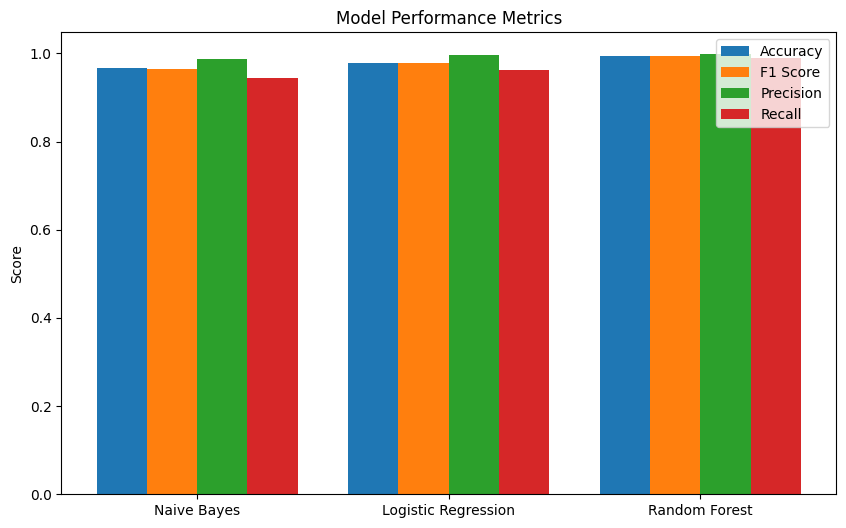

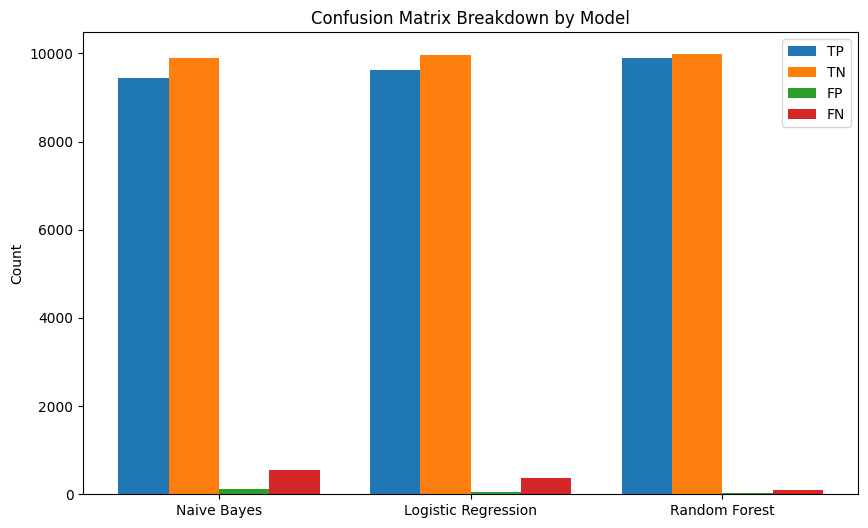

In [6]:
import matplotlib.pyplot as plt

# ===============================
# 📊 Plot Model Performance
# ===============================
metrics = ["Accuracy", "F1 Score", "Precision", "Recall"]

# Bar chart for main metrics
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar([x + i*0.2 for x in range(len(results_df))],
            results_df[metric], width=0.2, label=metric)

plt.xticks([x + 0.3 for x in range(len(results_df))], results_df["Model"])
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.legend()
plt.show()

# ===============================
# 📊 Plot Confusion Matrix Breakdown (TP, TN, FP, FN)
# ===============================
plt.figure(figsize=(10, 6))
confusion_parts = ["TP", "TN", "FP", "FN"]

for i, part in enumerate(confusion_parts):
    plt.bar([x + i*0.2 for x in range(len(results_df))],
            results_df[part], width=0.2, label=part)

plt.xticks([x + 0.3 for x in range(len(results_df))], results_df["Model"])
plt.ylabel("Count")
plt.title("Confusion Matrix Breakdown by Model")
plt.legend()
plt.show()


SAVING RANDOM FOREST 

In [7]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# ===============================
# 🎯 Base Random Forest
# ===============================
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# ===============================
# 📏 Calibrated Wrapper
# ===============================
# isotonic = more flexible (needs more data)
# sigmoid = Platt scaling (good if less data)
cal_rf = CalibratedClassifierCV(rf, cv=5, method='isotonic')

# Train on the whole dataset
cal_rf.fit(X, y)

# ===============================
# 💾 Save calibrated model
# ===============================
calibrated_package = {
    "model": cal_rf,
    "features": features
}

output_path = r"D:\QRMODELTRAINING\WHOISPKLMODELS\RF_qrusader_calibrated_whois.pkl"
joblib.dump(calibrated_package, output_path)

print(f"✅ Calibrated Random Forest model saved to: {output_path}")


✅ Calibrated Random Forest model saved to: D:\QRMODELTRAINING\WHOISPKLMODELS\RF_qrusader_calibrated_whois.pkl


MODEL TESTING FOR NEW URLS WITH WHOIS

In [15]:
import joblib
import pandas as pd
import re, math, time, dns.resolver
from collections import Counter
from urllib.parse import urlparse
from datetime import datetime
import whois
from concurrent.futures import ThreadPoolExecutor, as_completed

# ===============================
# 1️⃣ Load trained model
# ===============================
model_path = r"D:\QRMODELTRAINING\PKLMODELS\random_forest_qrusader_calibrated.pkl"
rf_package = joblib.load(model_path)

rf_model = rf_package["model"]
features = rf_package["features"]

print("✅ Random Forest model loaded with features:", features)

# ===============================
# 2️⃣ Helper functions
# ===============================
SUSPICIOUS_KEYWORDS = {"login", "verify", "secure", "account", "update", 
                       "bank", "free", "bonus", "signin", "paypal"}

def shannon_entropy(s):
    if not s: return 0
    probs = [c/len(s) for c in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

# ===============================
# 3️⃣ WHOIS feature extraction (robust)
# ===============================
def get_whois_features(url, retries=2, delay=1):
    """Extract WHOIS features with retries and graceful fallback."""
    domain = urlparse(url).netloc
    features = {
        "domain_age_days": 0,
        "domain_age_missing": 1,
        "dns_record": 0,
        "registrar_known": 0,
        "expiration_days": 0,
        "registration_length": 0,
        "whois_privacy": 0,
        "ns_count": 0
    }

    # Check DNS first
    try:
        dns.resolver.resolve(domain, 'A')
        features["dns_record"] = 1
    except:
        pass  # Leave default 0

    # WHOIS lookup with retries
    for attempt in range(retries):
        try:
            w = whois.whois(domain)
            features["registrar_known"] = 1 if w.registrar else 0
            features["domain_age_missing"] = 0

            # Creation date
            if w.creation_date:
                creation_date = w.creation_date[0] if isinstance(w.creation_date, list) else w.creation_date
                if creation_date:
                    features["domain_age_days"] = (datetime.now() - creation_date).days

            # Expiration date
            if w.expiration_date:
                exp_date = w.expiration_date[0] if isinstance(w.expiration_date, list) else w.expiration_date
                if exp_date:
                    features["expiration_days"] = (exp_date - datetime.now()).days

            # Registration length
            if w.creation_date and w.expiration_date:
                c_date = w.creation_date[0] if isinstance(w.creation_date, list) else w.creation_date
                e_date = w.expiration_date[0] if isinstance(w.expiration_date, list) else w.expiration_date
                if c_date and e_date:
                    features["registration_length"] = (e_date - c_date).days

            # Whois privacy detection
            if w.org and "privacy" in str(w.org).lower():
                features["whois_privacy"] = 1
            if w.emails and any("privacy" in str(e).lower() for e in (w.emails if isinstance(w.emails, list) else [w.emails])):
                features["whois_privacy"] = 1

            # Nameserver count
            if w.name_servers:
                features["ns_count"] = len(w.name_servers) if isinstance(w.name_servers, list) else 1

            break  # Success
        except:
            if attempt < retries - 1:
                time.sleep(delay)
            # else leave defaults

    return features

# ===============================
# 4️⃣ URL feature extraction
# ===============================
def extract_features(url, whois_info=None):
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path

    url_length = len(url)
    subdomain_count = max(len(domain.split('.')) - 2, 0)
    path_depth = len([p for p in path.split('/') if p])
    letters = sum(c.isalpha() for c in url)
    digits = sum(c.isdigit() for c in url)
    digit_letter_ratio = digits / letters if letters > 0 else 0
    special_chars = sum(not c.isalnum() for c in url)
    special_char_ratio = special_chars / len(url) if len(url) > 0 else 0
    repeated_char_count = sum(1 for i in range(1, len(url)) if url[i] == url[i-1])
    domain_entropy = shannon_entropy(domain)
    path_entropy = shannon_entropy(path)
    long_subdomain_length = max((len(p) for p in domain.split('.')[:-2]), default=0)
    query_param_count = url.count('&') + (1 if '?' in url else 0)
    vowel_count = sum(1 for c in url.lower() if c in 'aeiou')
    consonant_count = sum(1 for c in url.lower() if c.isalpha() and c not in 'aeiou')
    digit_special_ratio = digits / (special_chars + 1e-6)
    max_path_segment_length = max([len(seg) for seg in path.split('/')], default=0)

    has_ip = int(bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', url)))
    https_token = int(url.startswith('https'))
    url_has_suspicious_keywords = int(any(kw in url.lower() for kw in SUSPICIOUS_KEYWORDS))
    has_multiple_subdomains = int(subdomain_count > 1)

    # Merge WHOIS features
    whois_defaults = {
        'domain_age_days': 0,
        'expiration_days': 0,
        'registration_length': 0,
        'ns_count': 0,
        'domain_age_missing': 1,
        'dns_record': 0,
        'registrar_known': 0,
        'whois_privacy': 0
    }
    if whois_info:
        whois_defaults.update(whois_info)

    features_dict = {
        'url_length': url_length,
        'subdomain_count': subdomain_count,
        'path_depth': path_depth,
        'digit_letter_ratio': digit_letter_ratio,
        'special_char_ratio': special_char_ratio,
        'repeated_char_count': repeated_char_count,
        'domain_entropy': domain_entropy,
        'path_entropy': path_entropy,
        'long_subdomain_length': long_subdomain_length,
        'query_param_count': query_param_count,
        'vowel_count': vowel_count,
        'consonant_count': consonant_count,
        'digit_special_ratio': digit_special_ratio,
        'max_path_segment_length': max_path_segment_length,
        'has_ip': has_ip,
        'https_token': https_token,
        'url_has_suspicious_keywords': url_has_suspicious_keywords,
        'has_multiple_subdomains': has_multiple_subdomains,
        **whois_defaults
    }

    return features_dict

# ===============================
# 5️⃣ Test URLs (hard-to-detect malicious)
# ===============================
test_urls = [
    "https://google-secure-login.com/",         # Looks like Google login, but not actually
    "https://update-facebook-account.org/",     # Looks like Facebook phishing, but safe test domain
    "https://secure-paypal-verification.net/",  # Mimics Paypal, safe test domain
    "https://login.microsoft-support.info/",    # Looks like MS support
    "https://appleid-verification-online.com/", # Looks like Apple ID verification
    "https://github-secure-login-example.com/", # Looks like GitHub
    "https://dropbox-account-update.org/",      # Looks like Dropbox account page
    "https://steamcommunity-login-test.net/",   # Looks like Steam login
    "https://khanacademy-login-secure.org/",    # Mimics Khan Academy login
    "https://twitter-security-check-example.com/", # Looks like Twitter verification
    "https://linkedin-login-update.org/",       # Looks like LinkedIn login
    "https://bbc-account-security-test.net/",   # Looks like BBC account verification
    "https://arxiv-secure-upload.org/",         # Looks like Arxiv secure upload
    "https://stackoverflow-login-example.net/", # Looks like StackOverflow
    "https://ipqualityscore-safe-test.com/"     # Safe version of original
]



# ===============================
# 6️⃣ Run WHOIS in parallel
# ===============================
whois_results = {}
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_url = {executor.submit(get_whois_features, url): url for url in test_urls}
    for future in as_completed(future_to_url):
        url = future_to_url[future]
        try:
            whois_results[url] = future.result()
        except:
            whois_results[url] = None  # fallback

# ===============================
# 7️⃣ Extract features
# ===============================
X_test = [extract_features(url, whois_info=whois_results.get(url)) for url in test_urls]
X_test = pd.DataFrame(X_test)
X_test = X_test.reindex(columns=features, fill_value=0)

# ===============================
# 8️⃣ Predict & risk
# ===============================
probs = rf_model.predict_proba(X_test)

def risk_level(prob_malicious: float) -> str:
    if prob_malicious < 0.40:
        return "✅ Safe"
    elif prob_malicious < 0.70:
        return "⚠️ Medium Risk"
    else:
        return "🚨 High Risk"

results = []
for url, (prob_benign, prob_malicious) in zip(test_urls, probs):
    results.append({
        "URL": url,
        "Prob_Benign": round(float(prob_benign), 3),
        "Prob_Malicious": round(float(prob_malicious), 3),
        "Risk_Level": risk_level(prob_malicious)
    })

df_results = pd.DataFrame(results)
print("\n🔎 URL Risk Analysis:")
print(df_results.to_string(index=False))


✅ Random Forest model loaded with features: ['url_length', 'subdomain_count', 'path_depth', 'digit_letter_ratio', 'special_char_ratio', 'repeated_char_count', 'domain_entropy', 'path_entropy', 'long_subdomain_length', 'query_param_count', 'vowel_count', 'consonant_count', 'digit_special_ratio', 'max_path_segment_length', 'has_ip', 'https_token', 'url_has_suspicious_keywords', 'has_multiple_subdomains']


2025-09-24 15:12:07,439 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed



🔎 URL Risk Analysis:
                                        URL  Prob_Benign  Prob_Malicious  Risk_Level
           https://google-secure-login.com/        0.051           0.949 🚨 High Risk
       https://update-facebook-account.org/        0.006           0.994 🚨 High Risk
    https://secure-paypal-verification.net/        0.021           0.979 🚨 High Risk
      https://login.microsoft-support.info/        0.020           0.980 🚨 High Risk
   https://appleid-verification-online.com/        0.023           0.977 🚨 High Risk
   https://github-secure-login-example.com/        0.021           0.979 🚨 High Risk
        https://dropbox-account-update.org/        0.021           0.979 🚨 High Risk
     https://steamcommunity-login-test.net/        0.021           0.979 🚨 High Risk
      https://khanacademy-login-secure.org/        0.046           0.954 🚨 High Risk
https://twitter-security-check-example.com/        0.021           0.979 🚨 High Risk
         https://linkedin-login-update.org/